# Cleaning and EDA

 * [Read in Data](#rd)
 * [Data Cleaning](#dc)
 * [Google BigQuery](#gbq)
 * [Saving Necessary Model Data](#mod)

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import json

from google.cloud import bigquery

<a id='rd'></a>
## Read in Data

In [2]:
# Load data from csv
accidents_df = pd.read_csv('../data/US_Accidents_Dec20.csv')

In [ ]:
# Columns and data types
accidents_df.info()

In [ ]:
# Describe the data
accidents_df.describe()

In [ ]:
# Check for NULL values
accidents_df.isnull().sum()

In [ ]:
# Check frequent values for TMC to fill for NULL
accidents_df['TMC'].value_counts()

<a id='dc'></a>
## Data Cleaning

In [ ]:
accidents_df['TMC'].fillna(201.0, inplace=True)

In [ ]:
accidents_df['TMC'].value_counts()

In [ ]:
accidents_df['TMC'].isnull().sum()

In [ ]:
# Too many NULLs for End_Lat and End_Lng, so drop them. We can get most details using Start_Lat and Start_Lng anyway
accidents_df.drop(columns=['End_Lat', 'End_Lng'], inplace=True)

In [ ]:
accidents_df.info()

In [ ]:
# Drop all address related columns as we can derive it from Lat and Lng fields
accidents_df.drop(columns=['Number', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country'], inplace=True)

In [ ]:
# Drop Timezone as we won't be using it in our model and not needed for any EDA as well. Again, we could derive most of it using Lat/Lng
# Similarly, drop Airport_Code as well as it'll be multi-collinear with lat/lng. 
accidents_df.drop(columns=['Timezone', 'Airport_Code'], inplace=True)

In [ ]:
accidents_df.loc[:,['Weather_Timestamp', 'Start_Time', 'End_Time']].head(10)

In [ ]:
# Check if any Weather_Timestamp is outside of Start_Time and End_Time
accidents_df[(accidents_df['Weather_Timestamp'] < accidents_df['Start_Time']) & (accidents_df['Weather_Timestamp'] > accidents_df['End_Time'])]

In [ ]:
# Based on the above, Weather_Timestamp is **always** between Start_Time and End_Time so we can safely drop it
accidents_df.drop(columns=['Weather_Timestamp'], inplace=True)

In [ ]:
accidents_df['Temperature(F)'].value_counts()

In [ ]:
accidents_df['Temperature(F)'].describe()

In [ ]:
accidents_df['Temperature(F)'].plot(kind='box');

In [ ]:
# Find out mean and median of Temperature so we can fill it for NULL values
print(accidents_df['Temperature(F)'].mean())
print(accidents_df['Temperature(F)'].median())

In [ ]:
# Fill the median value for NULL values
accidents_df['Temperature(F)'].fillna(accidents_df['Temperature(F)'].median(), inplace=True)

In [ ]:
accidents_df['Wind_Chill(F)'].value_counts()

In [ ]:
accidents_df['Wind_Chill(F)'].describe()

In [ ]:
# Since Wind Chill is associated with Wind_Speed and Wind_Direction, lets check those values
accidents_df['Wind_Direction'].value_counts()

In [ ]:
# Based on the values of Wind_Direction, i don't think it'll be useful for our analysis. So, dropping that field completely.
#accidents_df.drop(columns=['Wind_Direction'], inplace=True)

In [ ]:
accidents_df['Wind_Speed(mph)'].value_counts()

In [ ]:
accidents_df['Wind_Speed(mph)'].describe()

In [ ]:
# Normally, temp, wind chill and wind speed are related in that wind chill is (temp - x*wind_speed) where x is simply 1 or some factor of it
# Lets check values here
accidents_df.loc[:,['Temperature(F)', 'Wind_Speed(mph)', 'Wind_Chill(F)']].head(15)

In [ ]:
# Above results confirms that theory. We can go ahead and calculate Wind_Chill(F) based on Wind_Speed(mph)
# If both Wind_Chill(F) and Wind_Speed(mph) are NULL, then we can use the Temperatur(F) instead assuming there is NO wind
# Finally, Wind_Speed(mph) is already part of Wind_Chill(F), we can drop that column.
# You could argue that Wind_Chill and Temp has linear relationship as they both mostly has similar values 
# but thats not always the case. So, we'll keep both of them and check for multi-collinearity when evaluating the model.

# First fill Wind_Chill using Wind_Speed where Wind_Chill = Temp-WindSpeed
accidents_df['Wind_Chill(F)'] = accidents_df.apply(lambda row: row['Temperature(F)'] - row['Wind_Speed(mph)'] if np.isnan(row['Wind_Chill(F)']) else row['Wind_Chill(F)'], axis=1)


In [ ]:
# Now, we're left with rows where wind_speed is also NULL. Fill in with temperature values
accidents_df['Wind_Chill(F)'] = accidents_df.apply(lambda row: row['Temperature(F)'] if np.isnan(row['Wind_Chill(F)']) else row['Wind_Chill(F)'], axis=1)

In [ ]:
# Drop Wind_Speed column as its captured in Wind_Chill already
accidents_df.drop(columns=['Wind_Speed(mph)'], inplace=True)

In [ ]:
# We filled most NULLs. Lets check where we stand now
accidents_df.isnull().sum()

In [ ]:
accidents_df['Humidity(%)'].value_counts()

In [ ]:
accidents_df['Humidity(%)'].describe()

In [ ]:
accidents_df['Weather_Condition'].value_counts()

In [ ]:
# Check the weather condition under which we're missing humidity values
accidents_df.loc[np.isnan(accidents_df['Humidity(%)']), ['Weather_Condition']].value_counts()

In [ ]:
# There is no easy way to fill Humidity % values. So, for now put it as 100% for all NULLs
accidents_df['Humidity(%)'].fillna(100.0, inplace=True)

In [ ]:
accidents_df['Pressure(in)'].value_counts()

In [ ]:
accidents_df['Pressure(in)'].describe()

In [ ]:
print(accidents_df['Pressure(in)'].mean())
print(accidents_df['Pressure(in)'].median())

In [ ]:
# Fill in Median value for Pressure(in)
accidents_df['Pressure(in)'].fillna(accidents_df['Pressure(in)'].median(), inplace=True)

In [ ]:
accidents_df['Visibility(mi)'].value_counts()

In [ ]:
accidents_df['Visibility(mi)'].describe()

In [ ]:
print(accidents_df['Visibility(mi)'].mean())
print(accidents_df['Visibility(mi)'].median())

In [ ]:
# Fill in Median value for Visibility(mi)
accidents_df['Visibility(mi)'].fillna(accidents_df['Visibility(mi)'].median(), inplace=True)

In [ ]:
accidents_df['Weather_Condition'].value_counts()

In [ ]:
accidents_df['Weather_Condition'].describe()

In [ ]:
# Fill Fair for All NULL Weather_Condition
accidents_df['Weather_Condition'].fillna('Fair', inplace=True)

In [ ]:
accidents_df['Precipitation(in)'].value_counts()

In [ ]:
# Check if weather condition when percipitation is NULL
accidents_df.loc[np.isnan(accidents_df['Precipitation(in)']), ['Weather_Condition']].value_counts().head(15)

In [ ]:
# Only about 20K records possbily might miss the actual Precipitation measurement. Other records should have 0.
accidents_df['Precipitation(in)'].fillna(0.0, inplace=True)

In [ ]:
# We will not be using description in the modeling. So, lets drop that field
accidents_df.drop(columns=['Description'], inplace=True)

In [ ]:
accidents_df['Sunrise_Sunset'].value_counts()

In [ ]:
accidents_df['Civil_Twilight'].value_counts()

In [ ]:
# What time of the day that we're missing values for Sunrise_Sunset related fields...
accidents_df.loc[accidents_df['Civil_Twilight'].isnull(), ['Start_Time', 'End_Time']].head(15)

In [ ]:
# We could derive the values from Start/End Time but since these are small number of records, lets put it as 'Day'
accidents_df['Civil_Twilight'].fillna('Day', inplace=True)

In [ ]:
accidents_df['Sunrise_Sunset'].fillna('Day', inplace=True)

In [ ]:
accidents_df['Nautical_Twilight'].fillna('Day', inplace=True)

In [ ]:
accidents_df['Astronomical_Twilight'].fillna('Day', inplace=True)

In [ ]:
# We filled all NULLs. Lets check where we stand now
accidents_df.isnull().sum()

In [ ]:
accidents_df.info()

In [3]:
# Lowercase column names
accidents_df.columns = accidents_df.columns.str.lower()

In [ ]:
# unnecessary
accidents_df.drop(columns=['id', 'source'], inplace=True)

In [4]:
# turn columns to datetime
accidents_df['start_time'] = pd.to_datetime(accidents_df['start_time'])
accidents_df['end_time'] = pd.to_datetime(accidents_df['end_time'])

In [5]:
# create a column that has the hour of the accident
accidents_df['start_hour'] = accidents_df['start_time'].dt.hour
accidents_df['end_hour'] = accidents_df['end_time'].dt.hour

In [6]:
# create a column that has the month of the accident
accidents_df['month'] = accidents_df['start_time'].dt.month

In [ ]:
# create a function to calculate the total duration of the accident in minutes

def datetime_to_minutes(df):
    total_duration = []
    
    for x in range(len(df)-1):
        total_duration.append(((df['end_time'][x] - df['start_time'][x]).total_seconds())/60)
        
    return total_duration

In [ ]:
# make a list of total duration
total_duration = datetime_to_minutes(accidents_df)

In [ ]:
total_duration.append(((accidents_df['end_time'][117247] - accidents_df['start_time'][117247]).total_seconds())/60)

In [ ]:
# create a column with the total duration of the accident
accidents_df['total_duration'] = total_duration

In [ ]:
def bool_to_int(bool):
    if bool == True:
        return 1
    else:
        return 0

In [ ]:
def bool_to_int_columns(df, columns):
    for col in columns:
        df[col] = df[col].apply(bool_to_int)
        
    return df

In [ ]:
# turn boolean columns into integers
accidents_df = bool_to_int_columns(accidents_df,['amenity','bump','crossing','give_way','junction','no_exit','railway',
                          'roundabout','station','stop','traffic_calming','traffic_signal',
                          'turning_loop'])

In [ ]:
def d_n_to_int(string):
    if string == 'Day':
        return 1
    else:
        return 0

In [ ]:
def d_n_to_int_columns(df, columns):
    for col in columns:
        df[col] = df[col].apply(d_n_to_int)
        
    return df

In [ ]:
# Turn night/day columns into integers
accidents_df = d_n_to_int_columns(accidents_df,['sunrise_sunset','civil_twilight',
                                'nautical_twilight','astronomical_twilight'])

In [ ]:
# dummify categorical columns
accidents_df = pd.get_dummies(accidents_df, columns = ['weather_condition','wind_direction','tmc'])

In [ ]:
# binarize side column
accidents_df['side'] = accidents_df['side'].map({'R': 1,'L': 0})

In [ ]:
# combine calm columns
accidents_df['wind_direction_Calm'] = accidents_df['wind_direction_Calm'] + accidents_df['wind_direction_CALM']

In [ ]:
# drop CALM column
accidents_df.drop(columns = ['wind_direction_CALM'], inplace = True)

In [ ]:
# taking out punctuation and other characters that aren't allowed
# to be uploaded in Google BigQuery

names = []

for col_names in accidents_df.columns:
    names.append(col_names.strip().replace('(','').replace(')','').replace('/','').replace('%','').replace(' ','').replace('-','_').replace('.0',''))

accidents_df.columns = names

In [ ]:
# Save the cleaned up version into csv
accidents_df.to_csv('US_Accidents_CleanedUp.csv')

<a id='gbq'></a>
## Google BigQuery

In [ ]:
# Jaco
with open('../../super_keys/dsi-team.json','r') as json_file:
    creds = json.load(json_file)

In [ ]:
# Nat
# with open('nats pathway','r') as json_file:
#     coin_creds = json.load(json_file)

In [ ]:
# Jonathan
# with open('jons pathway','r') as json_file:
#     coin_creds = json.load(json_file)

In [ ]:
# James
# with open('james pathway','r') as json_file:
#     coin_creds = json.load(json_file)

Ran the code below to upload our accidents_df to Google BigQuery.  Turning this cell into markdown so because it doesn't need to be reran.

accidents_df.to_gbq('accidents.accidents', project_id = creds['project_id'], if_exists = 'append',reauth = True)

In [ ]:
query = """
SELECT *
FROM `dsi-team-project.accidents.accidents`
"""

accidents = pd.read_gbq(query, project_id=creds['project_id'], reauth = True)

In [ ]:
accidents

<a id='mod'></a>
## Saving Necessary Model Data

Starting cleaning over because the data is so large that certain cleaning methods (get_dummies) requires more data than local CPU can handle.  As a result, we are going to create a virtual machine one Google Cloud Platform in order to handle the cleaning and modeling.

In [ ]:
# Load data from csv
accidents_df = pd.read_csv('../data/US_Accidents_Dec20.csv')

In [ ]:
# make columns lowercase
accidents_df.columns = accidents_df.columns.str.lower()

In [ ]:
# taking out punctuation and other characters to maintain commonality between datasets

names = []

for col_names in accidents_df.columns:
    names.append(col_names.strip().replace('(','').replace(')','').replace('/','').replace('%','').replace(' ','').replace('-','_').replace('.0',''))

accidents_df.columns = names

In [ ]:
# because multiple counties have the same name as others in different states,
# merging county and state to make them unique
accidents_df['county'] = accidents_df['county'] + accidents_df['state']

In [ ]:
# create balanced classes (severity 1 is the smallest with 29312 instances)
sev_1 = accidents_df[accidents_df['severity'] == 1]
sev_2 = accidents_df[accidents_df['severity'] == 2].head(29312)
sev_3 = accidents_df[accidents_df['severity'] == 3].head(29312)
sev_4 = accidents_df[accidents_df['severity'] == 4].head(29312)
selected = pd.concat([sev_1,sev_2,sev_3,sev_4], axis = 0).reset_index()

In [ ]:
# after initial model created using all of the features, choosing to select these
# features for final model
selected = selected[['severity','temperaturef','county','humidity','visibilitymi',
                     'wind_speedmph','precipitationin','traffic_signal','county',
                     'weather_condition','side','crossing','junction','stop',
                     'distancemi','wind_chillf','traffic_signal','sunrise_sunset',
                     'civil_twilight','nautical_twilight','astronomical_twilight',
                     'start_hour','end_hour','month','total_duration']]

In [ ]:
# save as csv
selected.to_csv('./selected.csv')

## EDA

In [7]:
accidents_df.head(1)

,id,source,tmc,severity,start_time,end_time,start_lat,start_lng,end_lat,end_lng,...,traffic_calming,traffic_signal,turning_loop,sunrise_sunset,civil_twilight,nautical_twilight,astronomical_twilight,start_hour,end_hour,month
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,Night,Night,Night,Night,5,11,2


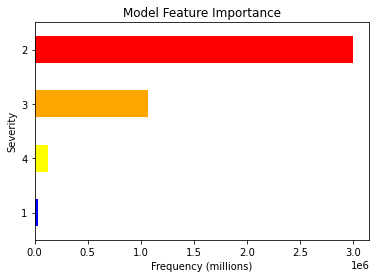

In [35]:
accidents_df['severity'].value_counts().plot(
    kind = 'barh', 
    color = ['red', 'orange', 'yellow', 'blue']
)

plt.legend().set_visible(False)
plt.xlabel('Frequency (millions)')
plt.ylabel('Severity')
plt.title('Model Feature Importance')
plt.gca().invert_yaxis();

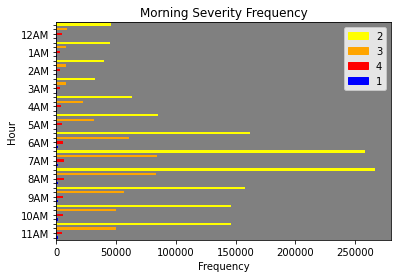

In [183]:
ax = accidents_df.groupby('start_hour')['severity'].value_counts().head(48).plot(
    kind = 'barh',
    color = ['yellow','orange','red','blue']
)

plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

positions = range(48)
labels = ('','','12AM','','','','1AM','','','','2AM','','','','3AM','','','','4AM',
          '','','','5AM','','','','6AM','','','','7AM','','','','8AM','','','','9AM',
          '','','','10AM','','','','11AM''','')
plt.yticks(positions,labels)

plt.legend(loc='lower right')
blue_patch = mpatches.Patch(color='blue', label='1')
red_patch = mpatches.Patch(color='yellow', label='2')
orange_patch = mpatches.Patch(color='orange', label='3')
yellow_patch = mpatches.Patch(color='red', label='4')
plt.legend(handles=[red_patch,orange_patch,yellow_patch,blue_patch])

ax.set_facecolor('grey')
plt.xlabel('Frequency')
plt.ylabel('Hour')
plt.title('Morning Severity Frequency')
plt.gca().invert_yaxis();

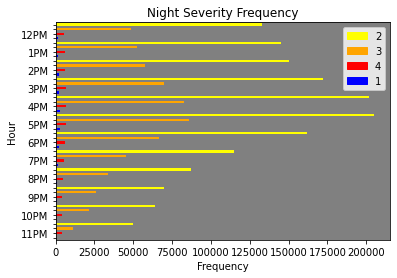

In [182]:
ax = accidents_df.groupby('start_hour')['severity'].value_counts().tail(48).plot(
    kind = 'barh',
    color = ['yellow','orange','red','blue']
)

plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

positions = range(48)
labels = ('','','12PM','','','','1PM','','','','2PM','','','','3PM','','','','4PM',
          '','','','5PM','','','','6PM','','','','7PM','','','','8PM','','','','9PM',
          '','','','10PM','','','','11PM''','')
plt.yticks(positions,labels)

plt.legend(loc='lower right')
blue_patch = mpatches.Patch(color='blue', label='1')
red_patch = mpatches.Patch(color='yellow', label='2')
orange_patch = mpatches.Patch(color='orange', label='3')
yellow_patch = mpatches.Patch(color='red', label='4')
plt.legend(handles=[red_patch,orange_patch,yellow_patch,blue_patch])

ax.set_facecolor('grey')
plt.xlabel('Frequency')
plt.ylabel('Hour')
plt.title('Night Severity Frequency')
plt.gca().invert_yaxis();

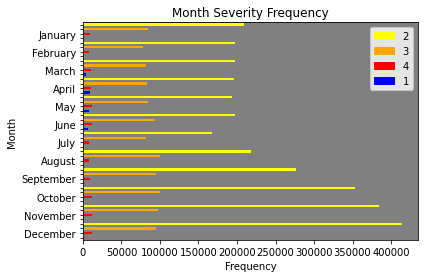

In [181]:
ax = accidents_df.groupby('month')['severity'].value_counts().tail(48).plot(
    kind = 'barh',
    color = ['yellow','orange','red','blue']
)

plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

positions = range(48)
labels = ('','','January','','','','February','','','','March','','','','April','','',
          '','May','','','','June','','','','July','','','','August','','','',
          'September','','','','October',
          '','','','November','','','','December','')
plt.yticks(positions,labels)

plt.legend(loc='lower right')
blue_patch = mpatches.Patch(color='blue', label='1')
red_patch = mpatches.Patch(color='yellow', label='2')
orange_patch = mpatches.Patch(color='orange', label='3')
yellow_patch = mpatches.Patch(color='red', label='4')
plt.legend(handles=[red_patch,orange_patch,yellow_patch,blue_patch])

ax.set_facecolor('grey')
plt.xlabel('Frequency')
plt.ylabel('Month')
plt.title('Month Severity Frequency')
plt.gca().invert_yaxis();

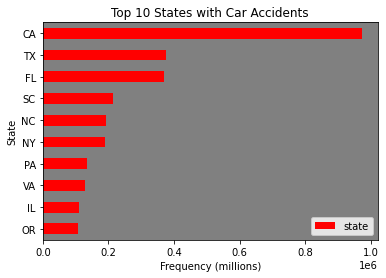

In [178]:
ax = accidents_df['state'].value_counts().head(10).plot(
    kind = 'barh', 
    color = 'red'
)

ax.set_facecolor('grey')
plt.legend(loc='lower right')
plt.xlabel('Frequency (millions)')
plt.ylabel('State')
plt.title('Top 10 States with Car Accidents',color = 'black')
plt.gca().invert_yaxis();

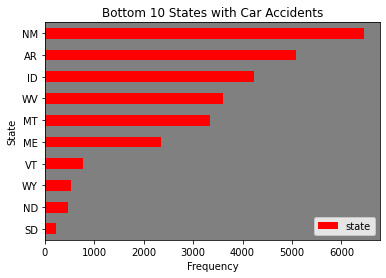

In [177]:
ax = accidents_df['state'].value_counts().tail(10).plot(
    kind = 'barh', 
    color = 'red'
)

ax.set_facecolor('grey')
plt.legend(loc='lower right')
plt.xlabel('Frequency')
plt.ylabel('State')
plt.title('Bottom 10 States with Car Accidents',color = 'black')
plt.gca().invert_yaxis();

In [50]:
# because multiple counties have the same name as others in different states,
# merging county and state to make them unique
accidents_df['county_state'] = accidents_df['county'] + accidents_df['state']

In [52]:
# because multiple cities have the same name as others in different states,
# merging city and state to make them unique
accidents_df['city_state'] = accidents_df['city'] + accidents_df['state']

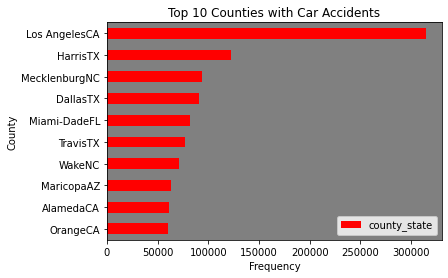

In [176]:
ax = accidents_df['county_state'].value_counts().head(10).plot(
    kind = 'barh', 
    color = 'red'
)

ax.set_facecolor('grey')
plt.legend(loc='lower right')
plt.xlabel('Frequency')
plt.ylabel('County')
plt.title('Top 10 Counties with Car Accidents',color = 'black')
plt.gca().invert_yaxis();

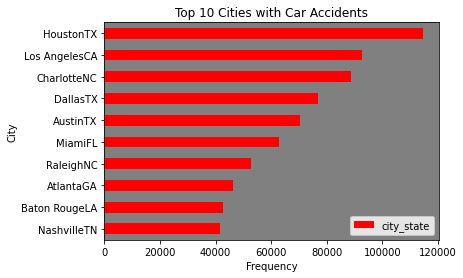

In [175]:
ax = accidents_df['city_state'].value_counts().head(10).plot(
    kind = 'barh', 
    color = 'red'
)

ax.set_facecolor('grey')
plt.legend(loc='lower right')
plt.xlabel('Frequency')
plt.ylabel('City')
plt.title('Top 10 Cities with Car Accidents',color = 'black')
plt.gca().invert_yaxis();

In [55]:
# https://worldpopulationreview.com/us-cities
city_pop = pd.read_csv('./population/2021_city_pop.csv')

In [56]:
# https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/
state_pop = pd.read_csv('./population/2019_state_pop.csv')

In [57]:
# https://worldpopulationreview.com/us-counties
county_pop = pd.read_csv('./population/county_pop.csv')

<ipython-input-174-8a7c57036440>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ax = county_pop.groupby('County')['County','pop2021'].sum().sort_values(


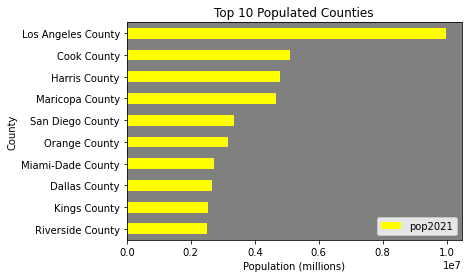

In [174]:
ax = county_pop.groupby('County')['County','pop2021'].sum().sort_values(
    by = 'pop2021', ascending = False).head(10).plot(
    kind = 'barh',
    color = ['yellow']
)

ax.set_facecolor('grey')
plt.legend(loc='lower right')
plt.xlabel('Population (millions)')
plt.ylabel('County')
plt.title('Top 10 Populated Counties',color = 'black')
plt.gca().invert_yaxis();

<ipython-input-173-394033dc9030>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ax = city_pop.groupby('name')['name','pop2021'].sum().sort_values(


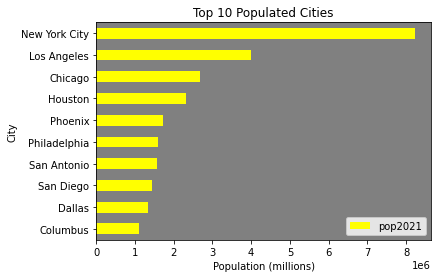

In [173]:
ax = city_pop.groupby('name')['name','pop2021'].sum().sort_values(
    by = 'pop2021', ascending = False).head(10).plot(
    kind = 'barh',
    color = ['yellow']
)

ax.set_facecolor('grey')
plt.legend(loc='lower right')
plt.xlabel('Population (millions)')
plt.ylabel('City')
plt.title('Top 10 Populated Cities',color = 'black')
plt.gca().invert_yaxis();

<ipython-input-172-56dc925764ef>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ax = state_pop.groupby('NAME')['NAME','POPESTIMATE2019'].sum().sort_values(


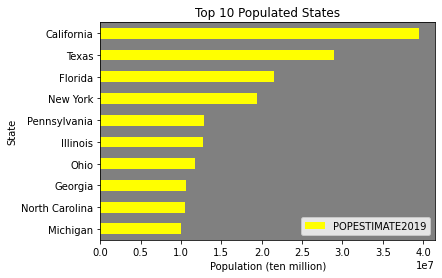

In [172]:
ax = state_pop.groupby('NAME')['NAME','POPESTIMATE2019'].sum().sort_values(
    by = 'POPESTIMATE2019', ascending = False)[1:11].plot(
    kind = 'barh',
    color = ['yellow']
)

ax.set_facecolor('grey')
plt.legend(loc='lower right')
plt.xlabel('Population (ten million)')
plt.ylabel('State')
plt.title('Top 10 Populated States',color = 'black')
plt.gca().invert_yaxis();

<ipython-input-171-6c3f5b8ed78e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ax = state_pop.groupby('NAME')['NAME','POPESTIMATE2019'].sum().sort_values(


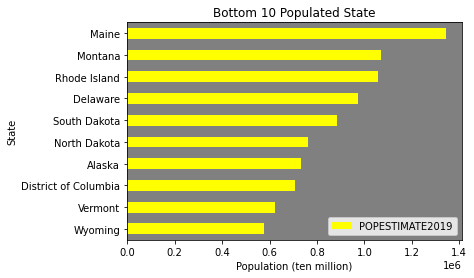

In [171]:
ax = state_pop.groupby('NAME')['NAME','POPESTIMATE2019'].sum().sort_values(
    by = 'POPESTIMATE2019').head(10).plot(
    kind = 'barh',
    color = ['yellow']
)

plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

ax.set_facecolor('grey')
plt.legend(loc='lower right')
plt.xlabel('Population (ten million)')
plt.ylabel('State')
plt.title('Bottom 10 Populated State',color = 'black');